# 概述
包括文本嵌入层和位置编码

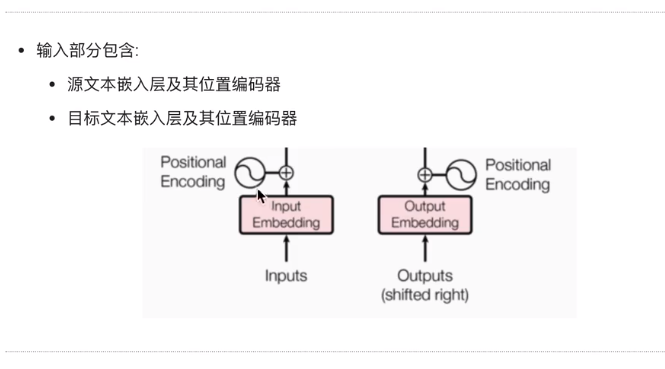

# 2.1 Embedding

- 作用：

嵌入：将文本中词汇的数字表示（词汇向量）转化为高维向量表示，希望再这样的高维空间捕获词汇间的关系。

- pytorch 0.3.0及其必备工具包的安装

使用pip安装的工具包包括pytorch-0.3.，numpy，matplotlib，seabornpip 

- 文本嵌入层的代码分析:

关键逻辑: 

    embedding = nn.Embedding(vocab, d_model)
    return embedding(input)* math.sqrt(self.d_model)

在这段代码中，src = self.encoder(src) * math.sqrt(self.d_model)，
        乘以math.sqrt(self.d_model)的目的是为了缩放嵌入向量的数值范围。

        在Transformer模型中，嵌入层用于将离散的输入类别（如单词或标签）映射到连续的向量表示。这些嵌入向量的维度由d_model参数指定。

        通过乘以math.sqrt(self.d_model)，可以缩放嵌入向量的数值范围。
        这是因为在Transformer模型中，嵌入向量与位置编码向量相加后，会传递给编码器进行处理。
        如果嵌入向量的数值范围过大，可能会导致梯度消失或梯度爆炸的问题。通过缩放嵌入向量，可以在一定程度上缓解这些问题，提高模型的训练效果和稳定性。

        总结起来，乘以math.sqrt(self.d_model)是为了缩放嵌入向量的数值范围，以提高模型的训练效果和稳定性。

In [ ]:
import torch

#预定义的网络层torch.nn，工具开发者已经帮助我们开发好的一些常用层.
#比如，卷积层，lstm层， embedding层等，不需要我们再重新造轮子.
import torch.nn as nn

#数学计算工具包
import math

# torch中变量封装函数Variable.
from torch.autograd import Variable

#定义Embeddings类来实现文本嵌入层，这里s说明代表两个一模一样的嵌入层，他们共享参数
#该类继承nn.Module，这样就有标准层的一些功能，这里我们也可以理解为一种模式，我们自己实现的所有层
class Embeddings(nn.Module):
    def __init__(self,d_model,vocab):
        '''类的初始化函数，有两个参数: 
        d_model: 指词嵌入的维度
        vocab: 指词表的大小'''
		#接着就是使用super的方式指明继承nn.Module的初始化函数，我们自己实现的所有层都会这样去继承
        super(Embeddings, self).__init__()
		#之后就是调用nn中的预定义层Embedding，获得一个词嵌入对象self.lut
        self.lut = nn.Embedding(vocab, d_model)
		#最后就是将d_model传入类中
        self.d_model = d_model
    
    def forward(self, x):
        """
        可以将其理解为该层的前向传播逻辑，所有层中都会有此函数
        当传参数给该类的实例化对象时，自动调用该函数
        """
        # 参数x:因为Embedding层是首层，所以代表输入给模型的文本通过词汇映射后的张
        # 例如两个词“hello world”：[[1,2,3,4],[4,3,2,1]]

        # 将x传给self.lut并与根号下self.d_model相乘作为结果返回
        # 原文：In the embedding layers, we multiply those weights by √d_model
        return self.lut(x) * math.sqrt(self.d_model)

In [ ]:
d_model = 512
vocab = 1000
x = Variable(torch.LongTensor([[1,2,3,4],[4,3,2,1]]))
emb = Embeddings(d_model, vocab)
embr = emb(x)
print("embr:",embr)

# 2.2 Position Encoding

- 位置编码器的作用:

因为Transformer的编码器结构中,并没有针对词汇位置信息的处理，因此需要在Embedding层后加入位置编码器。

将词汇位置不同可能产生的不同语义信息，加入到词嵌入张量中，以弥补位置信息的缺失

    x: 代表文本序列的词嵌入表示,大小是batch_size * max_len * d_model
    pe: 位置编码矩阵，大小是1 * max_len * d_model
    两者相加。
    

- 计算规则：

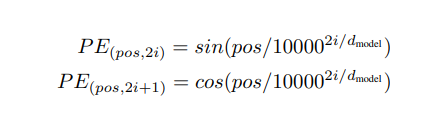


- 位置编码器的代码分析:

In [ ]:
#构建位置编码器的类
class PositionalEncoding(nn.Module):
    def _init_(self,d_model, dropout,max_len=5000):
        # d_model:代表词入的维度
        # dropout: 代表Dropout层的置零比率
        # max_len: 代表每隔句子的最大长度
        super(PositionalEncoding,self).__init__()

        #实例化Dropout层
        self.dropout = nn.Dropout(p=dropout)
        
        #初始化一个位置编码矩阵,大小是max_len * d_model
        pe = torch.zeros(max_len,d_model)
        
        #初始化一个绝对位置矩阵,max_len *1
        position = torch.arange(0,max_len).unsqueeze(1)
        
        #定义一个变化矩阵div_term,跳跃式的初始化
        div_term = torch.exp(torch.arange(0,d_model,2)*-(math.log(10000.0) / d_model))
        
        #将前面定义的变化矩阵进行奇数,偶数的分别赋值
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2]= torch.cos(position * div_term)

        #将二维张量扩充成三维张量
        pe = pe.unsqueeze(0)
        
        #将位置编码矩阵注册成模型的buffer，这个buffer不是模型中的参数
        #注册成buffer后我们就可以在模型保存后重新加载的时候，直接加载
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x: 代表文本序列的词嵌入表示,大小是batch_size * max_len * d_model
        # 加上位置编码矩阵pe，大小是1 * max_len * d_model
        # pe的编码太长了，将第二个维度， 也就是max_len对应的那个维度缩小成x的句子长度
        x= x + Variable(self.pe[:, x.size(1)], requires_grad=False)
        return self.dropout(x)

In [ ]:
d_model = 512
dropout= 0.1
max_len = 60

x = embr
pe = PositionalEncoding(d_model, dropout, max_len)
pe_result = pe(x)
print(pe_result)
print(pe_result.shape)